# 1. Importing packages

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os

from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [4]:
path = '../data/'

# 2. Visualising data

In [5]:
names = []
nums = []
data = {'Name of class':[],'Number of samples':[]}

for i in os.listdir(path+'/train'):
    nums.append(len(os.listdir(path+'/train/'+i)))
    names.append(i)

data['Name of class']+=names
data['Number of samples']+=nums

df = pd.DataFrame(data)
df

,Name of class,Number of samples
0,cat,700
1,deer,600
2,dog,900
3,horse,600


<AxesSubplot:xlabel='Name of class', ylabel='Number of samples'>

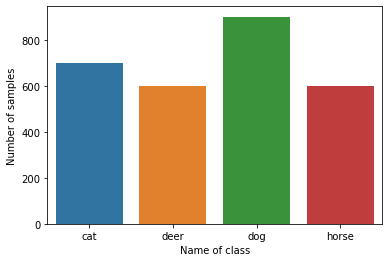

In [6]:
sns.barplot(x=df['Name of class'],y=df['Number of samples'])

['cat', 'deer', 'dog', 'horse']


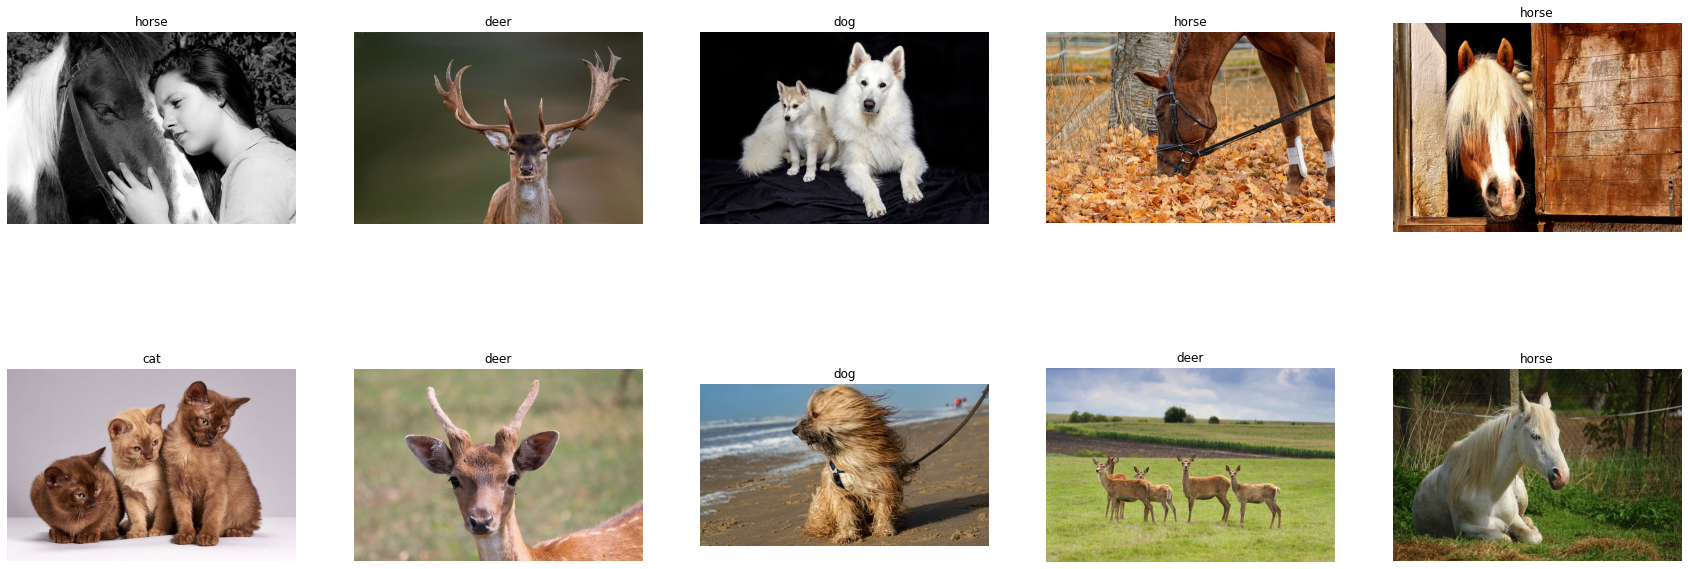

In [8]:
classes = os.listdir(path+'/train')
print(classes)

plt.figure(figsize=(30 , 30))
for x in range(10):
    i = random.randint(0,3)                    # getting the class
    images = os.listdir(path+'/train'+'/'+classes[i])
    j = random.randint(0,600)                  # getting the image
    image = cv2.imread(path+'/train'+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

# 3. Preparing the data

In [9]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255 , rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True, validation_split=0.2)

In [13]:
train_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='training',
        target_size=(299 , 299),
        batch_size=32)

Found 2240 images belonging to 4 classes.


In [14]:
val_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='validation',
        target_size=(299 , 299),
        batch_size=32 )

Found 560 images belonging to 4 classes.


# Modeling

### Load Pretrained Model

In [16]:
# base model
base_model = tf.keras.applications.mobilenet.MobileNet(
    input_shape=(299 , 299, 3),
    include_top=False,
    weights='imagenet'
)

# base_model.trainable = False
base_model.summary()
# feature_beach = base_model(train_ds)
base_model.trainable = False

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 150, 150, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 150, 150, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 150, 150, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 150, 150, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 150, 150, 32)     128       
 ation)                                         

In [17]:
# using mobilenet

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(4, activation="softmax" , name="classification"))

In [18]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 9, 9, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 classification (Dense)      (None, 4)                 2

# 5. Training and evaluating

In [20]:
history = model.fit(train_ds , validation_data = val_ds , epochs = 3)

Epoch 1/3
70/70 [==============================] - 254s 4s/step - loss: 0.6853 - accuracy: 0.7848 - val_loss: 0.3584 - val_accuracy: 0.9054
Epoch 2/3
70/70 [==============================] - 238s 3s/step - loss: 0.2322 - accuracy: 0.9473 - val_loss: 0.2180 - val_accuracy: 0.9393
Epoch 3/3
70/70 [==============================] - 278s 4s/step - loss: 0.1584 - accuracy: 0.9621 - val_loss: 0.1743 - val_accuracy: 0.9518


18/18 [==============================] - 56s 3s/step - loss: 0.1836 - accuracy: 0.9339


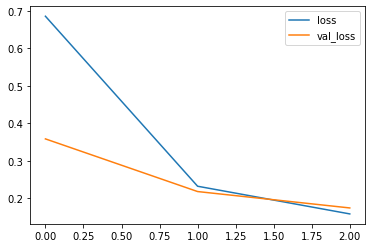

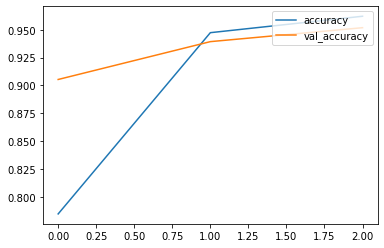

In [21]:
model.evaluate(val_ds)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

In [22]:
test_ds = image_datagen.flow_from_directory(
        path+'/test',
        subset='training',
        target_size=(299 , 299),
        batch_size=32)

Found 584 images belonging to 1 classes.


In [29]:
predict = model.predict(test_ds)

19/19 [==============================] - 54s 3s/step


In [30]:
predict = np.argmax(predict , axis = 1)

In [31]:
labels = classes

predicted = [labels[k] for k in predict]

print(predicted[:5])

['horse', 'horse', 'deer', 'dog', 'deer']


1/1 [==============================] - 0s 87ms/step


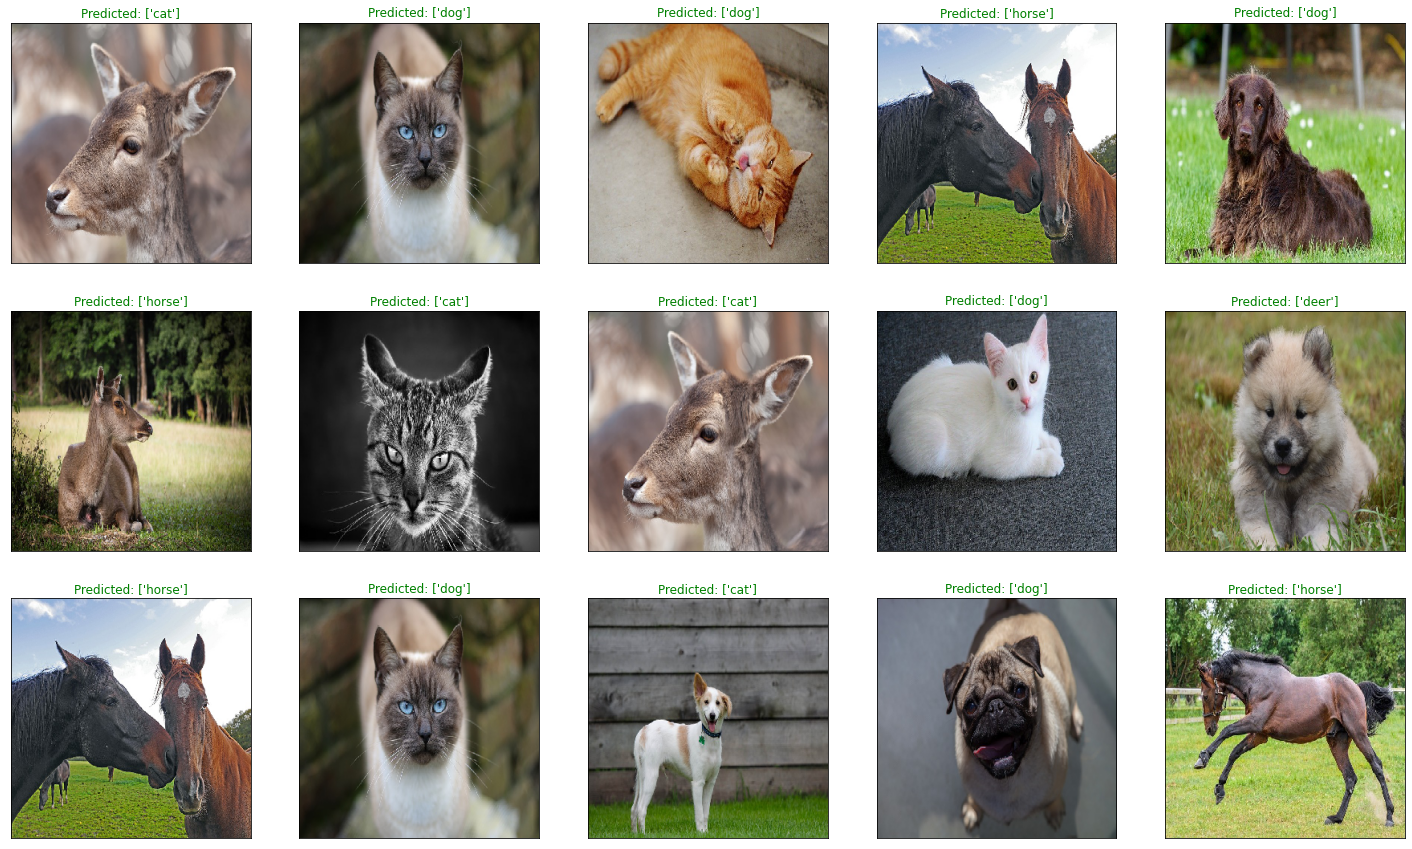

<Figure size 432x288 with 0 Axes>

In [34]:
from tensorflow.keras.preprocessing import image

random_index = np.random.randint(1, len(test_ds) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = image.load_img(path+'test/test/'+str(random_index[i])+'.jpg', target_size=(299, 299))
    ax.imshow(img)
    img = image.img_to_array(img)
    img_arr = np.expand_dims(img, 0)
    # img_arr = tf.keras.applications.mobilenet_v3.preprocess_input(img_arr)
    pred = model.predict(img_arr)
    
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (classes)
    # labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    ax.set_title(f"Predicted: {pred}", color='green')
plt.show()
plt.tight_layout()

In [36]:
# accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(test_ds.classes, predict)


0.2671232876712329

# 6. Preparing for submission

In [194]:
sub_csv ='../input/4-animal-classification/Sample_submission.csv'
path_test = '../input/4-animal-classification/test/test'

In [195]:
df_sub = pd.read_csv(sub_csv)
image_id = df_sub['ID']
df_sub.head(10)

,ID,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [196]:
# each image will be treated individually and saved in a list which is then merged with the id of it's correspondence

from tensorflow.keras.preprocessing.image import load_img


# making a list for our predictions
labels = []


for i in image_id:
    image = load_img(path_test+'/'+str(i)+'.jpg', target_size=(224, 224))
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,224,224,3)
    label = model.predict(img)
    label_id = label[0].tolist()
    
    labels.append(label_id.index(max(label_id)))


ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py:269 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer sequential_16: expected shape=(None, 299, 299, 3), found shape=(None, 224, 224, 3)


In [ ]:
# we will replace the previous empty columns with the new predictions    
    
df_sub['Label'] = labels
df_sub.head(10)

In [ ]:
# saving file
df_sub.to_csv('submission_file.csv',index=False)